    classifiers used

        regression
            linear regression >> with polyfeatures
            logistic regression
            lasso regression
            ridge regression

        knn
        desicion tree
        svm
        naivebias

        ensemble methods:
            bagging
                random forest 

            boosting
                gradient boost  
                ada boost
                xg boost
                cat boost


        hyperparameter tuning(depending on model):
            grid search


        evaluation and validation :
            cross validation
            ROC-AUC curve
            r2 score
            confuction matrix

## imports

In [6]:
import sklearn as sk
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from IPython.display import display


In [7]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report , r2_score
import numpy as np
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.svm import SVC


import seaborn as sns
import hvplot.pandas

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_columns", 80)
pd.set_option("display.max_rows", 80)


## helper functions for plotting and visualization


In [8]:
# helper functions for plotting and visualization

#  for plotting confusion matrix
def plot_confusion_matrix(model, x_test, y_test):
    cm = confusion_matrix(y_test, model.predict(x_test))
    # cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    score = model.score(x_test, y_test)
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5,
                square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size=15)


# for printing the precision , recall , f1-score , ROC(AOC) , classification report
def print_metrics(model, x_train, x_test, y_train, y_test):
    print("The Training Accuracy is: ", model.score(x_train, y_train))
    print("The Testing Accuracy is: ", model.score(x_test, y_test))
    y_pred = model.predict(x_test)
    r2__score = r2_score(y_test, y_pred)
    
    precision = precision_score(y_test, y_pred, average='weighted', 
                          labels=np.unique(y_pred))
    
    recall = recall_score(y_test, y_pred, average='weighted',
                          labels=np.unique(y_pred))

    score=f1_score(y_test, y_pred, average = 'weighted',
                     labels=np.unique(y_pred))
    
    ROC_AUC = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    print("The R2 score is: ", r2__score)
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('F1-Measure: %.3f' % score)
    print('ROC_AUC: %.3f' % ROC_AUC)
    print(
        f'the classification report is \n {classification_report(y_test, y_pred , labels=np.unique(y_pred))}')


# for plotting the ROC curve (takes the model and test data as inputs)
def plot_roc(model, name,  x_test, y_test):
    pred_prob = model.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:, 1])

    # roc curve for tpr = fpr
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(10, 10))
    plt.style.use('seaborn')

    plt.plot(fpr, tpr, linestyle='--', color='green',
             label=f'{name} ROC (AUC = %0.4f)' % auc_score)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.legend(loc='lower right')
    plt.title("ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.show()


## data preprocessing and EDA

    >>> 

In [9]:
import glob
path = glob.glob(r'./IBM/*.csv')
path

['./IBM\\WA_Fn-UseC_-HR-Employee-Attrition.csv']

In [10]:
df = pd.read_csv(path[0])

In [11]:
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [12]:
# print(df.info())
# display(df.describe())

In [13]:
print('size of the original dataframe is: ', df.shape)

size of the original dataframe is:  (1470, 35)


In [14]:
print('max perf' , df['PerformanceRating'].max())
print('min perf',df['PerformanceRating'].min())
# print(df['PerformanceRating'].head())
for column in df[['Attrition', 'PerformanceRating']].columns:
    print(f"{column}: Number of unique values {df[column].nunique()}")
    print("==========================================================")


max perf 4
min perf 3
Attrition: Number of unique values 2
PerformanceRating: Number of unique values 2


In [15]:
df['Attrition'].replace(['Yes', 'No'], [1, 0], inplace=True)
print(df['Attrition'].head().to_markdown())


|    |   Attrition |
|---:|------------:|
|  0 |           1 |
|  1 |           0 |
|  2 |           1 |
|  3 |           0 |
|  4 |           0 |


In [16]:
from sklearn.preprocessing import LabelEncoder
categorical_col = []
for column in df.columns:
    if df[column].dtype == object and df[column].nunique() < 10:
        categorical_col.append(column)

# df['Attrition'] = df.Attrition.astype("category").cat.codes
# categorical_col.remove('Attrition')
label = LabelEncoder()
for column in categorical_col:
    df[column] = label.fit_transform(df[column])

# now the dataset is all numerical

<AxesSubplot:>

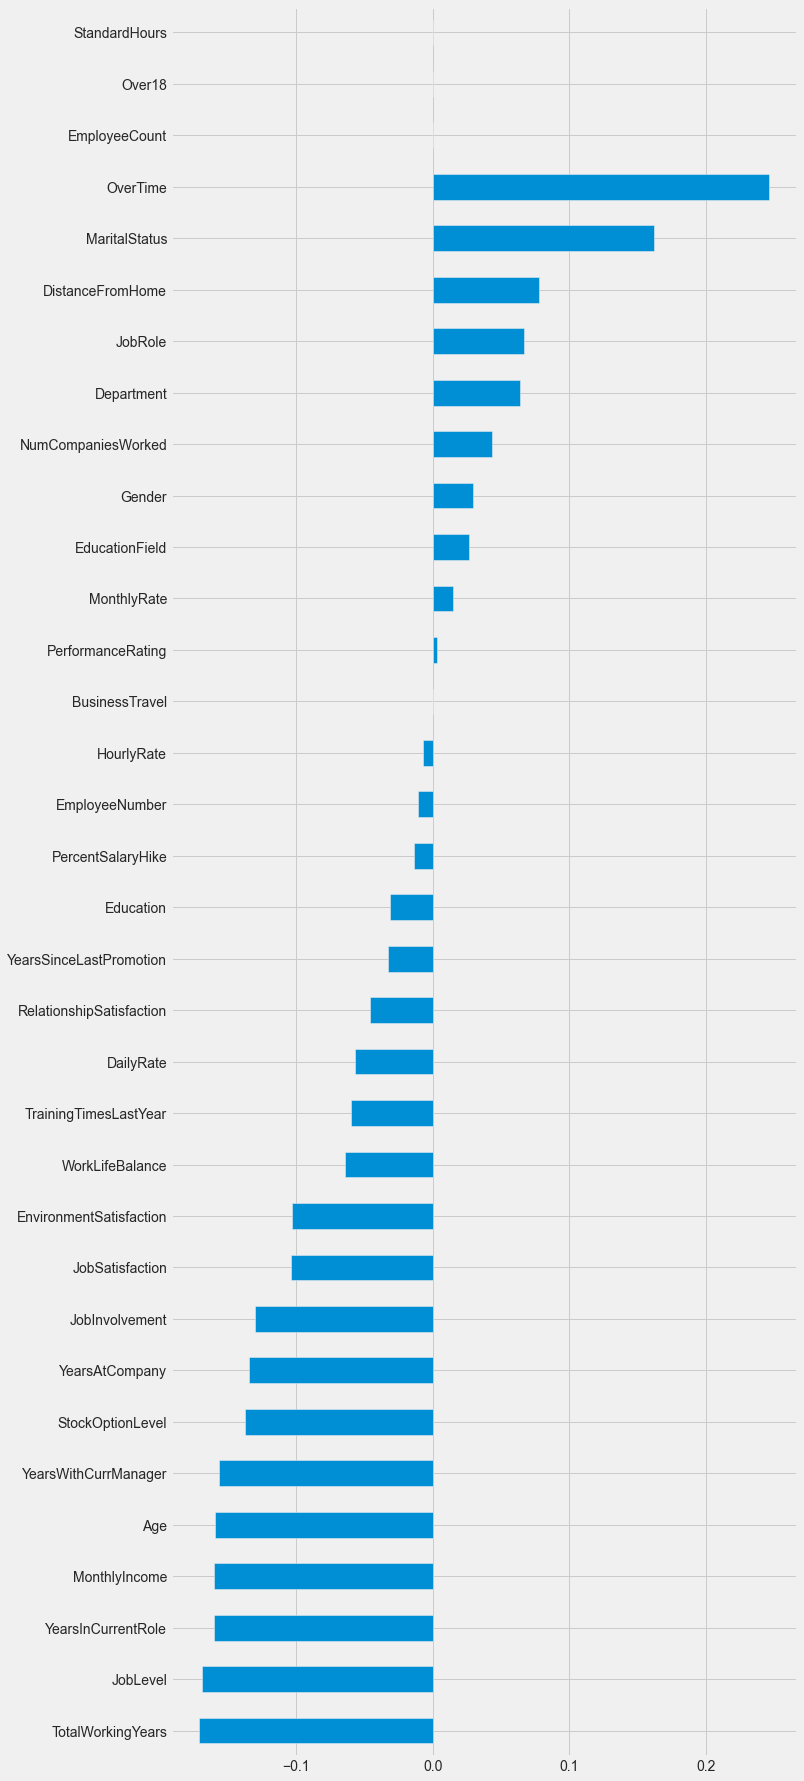

In [17]:
df.drop('Attrition', axis=1).corrwith(
    df.Attrition).sort_values().plot(kind='barh', figsize=(10, 30))


In [18]:
# as we see there is no correlation between the attrition and ( 'EmployeeCount', 'EmployeeNumber', 'Over18','StandardHours')
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18',
        'StandardHours', 'BusinessTravel'], axis="columns", inplace=True)


In [19]:
# x = np.array(df.drop(['Attrition', 'PerformanceRating'], axis=1))
x = np.array(df.drop(['Attrition'], axis=1))
y = np.array(df['Attrition'])

print(df.shape)
print(x.shape)
print(y.shape)


(1470, 30)
(1470, 29)
(1470,)


In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)
# x_train_attr, x_test_attr, y_train_attr, y_test_attr = train_test_split(
#     x, y_attrition, test_size=0.2, random_state=42)
# x_train_perf, x_test_perf, y_train_perf, y_test_perf = train_test_split(
#     x, y_performance, test_size=0.2, random_state=42)
# print(len(x_train_attr) ,len(x_test_attr) ,len(y_train_attr) ,len(y_test_attr))
scaler = StandardScaler()
X_train_std = scaler.fit_transform(x_train)
X_test_std = scaler.transform(x_test)


## various models training , tuning and Evaluation 
        each model has 2 copies trained and tuned >> (for both attrition and for performance)
        first we run all the models on attrition then run the same code for performance later

### KNN

In [21]:
k_values = [i for i in range(1, 60)]
k_acc_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    cv_scores = cross_val_score(knn, x, y, cv=10)
    k_acc_scores.append(cv_scores.mean())



In [22]:
max_index = k_acc_scores. index(max(k_acc_scores))
print(max_index+1, k_acc_scores[max_index])


10 0.84421768707483


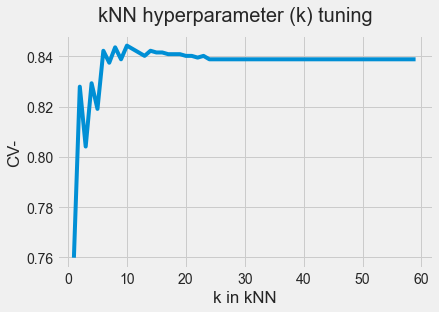

In [23]:
fig2 = plt.figure()
plt.plot(k_values, k_acc_scores)
plt.xlabel('k in kNN')
plt.ylabel('CV-')
fig2.suptitle('kNN hyperparameter (k) tuning ', fontsize=20)
plt.show()



In [24]:
model_knn = KNeighborsClassifier(n_neighbors=max_index+1, n_jobs=-1)
model_knn.fit(x_train,y_train)


KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

The Training Accuracy is:  0.8402903811252269
The Testing Accuracy is:  0.8586956521739131
The R2 score is:  -0.24583333333333335
Precision: 0.755
Recall: 0.859
F1-Measure: 0.803
ROC_AUC: 0.540
the classification report is 
               precision    recall  f1-score   support

           0       0.87      0.99      0.92       320
           1       0.00      0.00      0.00        48

    accuracy                           0.86       368
   macro avg       0.43      0.49      0.46       368
weighted avg       0.75      0.86      0.80       368



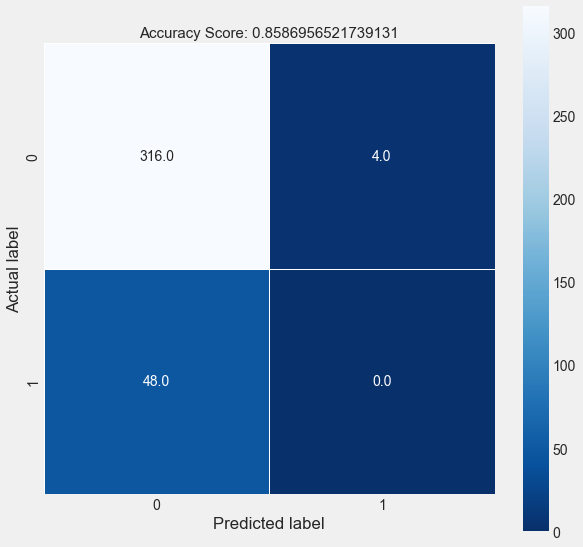

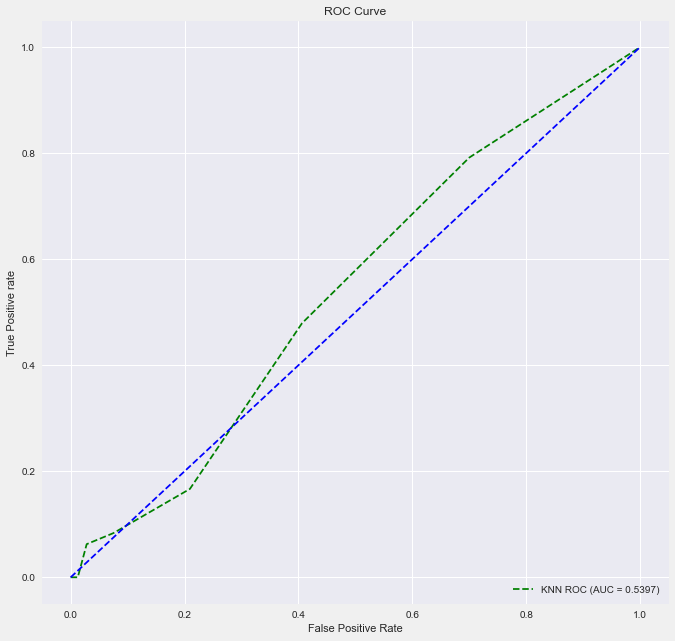

In [25]:
print_metrics(model_knn, x_train, x_test, y_train, y_test)
plot_confusion_matrix(model_knn, x_test, y_test)
plot_roc(model_knn, 'KNN', x_test, y_test)


### Naive bayes

In [26]:
model_NB = GaussianNB()
model_NB.fit(x_train,y_train)
pre=model_NB.predict(x_test)

The Training Accuracy is:  0.7813067150635209
The Testing Accuracy is:  0.8070652173913043
The R2 score is:  -0.7010416666666666
Precision: 0.853
Recall: 0.807
F1-Measure: 0.825
ROC_AUC: 0.710
the classification report is 
               precision    recall  f1-score   support

           0       0.93      0.84      0.88       320
           1       0.35      0.56      0.43        48

    accuracy                           0.81       368
   macro avg       0.64      0.70      0.66       368
weighted avg       0.85      0.81      0.82       368



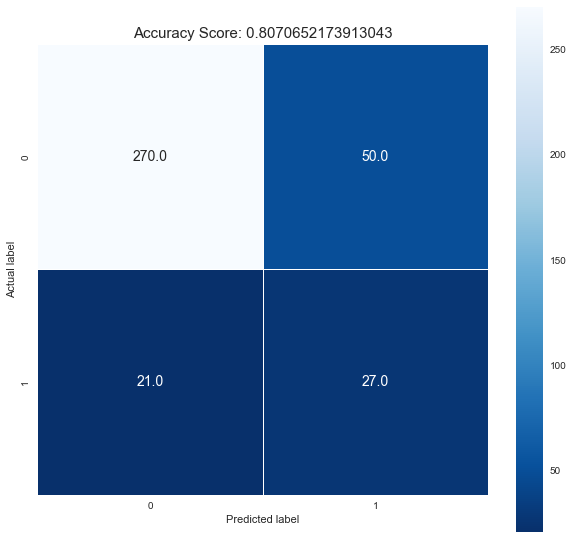

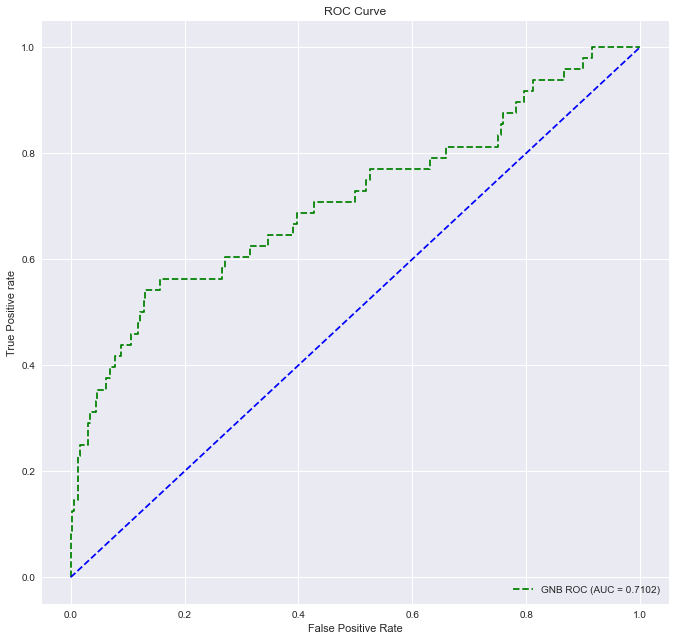

In [27]:
print_metrics(model_NB , x_train , x_test , y_train , y_test)
plot_confusion_matrix(model_NB , x_test , y_test)
plot_roc(model_NB , 'GNB' , x_test , y_test)

### Logistic Regression


In [28]:
model = LogisticRegression(max_iter=1000000)
model.fit(x_train,y_train)
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [29]:
print_metrics(model, x_train, x_test, y_train, y_test)


The Training Accuracy is:  0.868421052631579
The Testing Accuracy is:  0.8858695652173914
The R2 score is:  -0.006250000000000089
Precision: 0.867
Recall: 0.886
F1-Measure: 0.865
ROC_AUC: 0.772
the classification report is 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       320
           1       0.65      0.27      0.38        48

    accuracy                           0.89       368
   macro avg       0.77      0.62      0.66       368
weighted avg       0.87      0.89      0.86       368



In [30]:
param_grid = [
    {
        'penalty': ['l2', 'l1', 'elasticnet', 'none'],
        'C': [100, 10, 1.0, 0.1, 0.01],
        # 'C'  : np.logspace(-4, 4, 20),
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    }
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
best_model_search = GridSearchCV(LogisticRegression(
    max_iter=1000000), param_grid=param_grid, n_jobs=-1, cv=cv, verbose=True, scoring='accuracy', error_score=0)
grid_result = best_model_search.fit(x_train, y_train)
model_log_reg = grid_result.best_estimator_


Fitting 30 folds for each of 60 candidates, totalling 1800 fits


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
900 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_mode

In [31]:
model_log_reg.get_params()


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

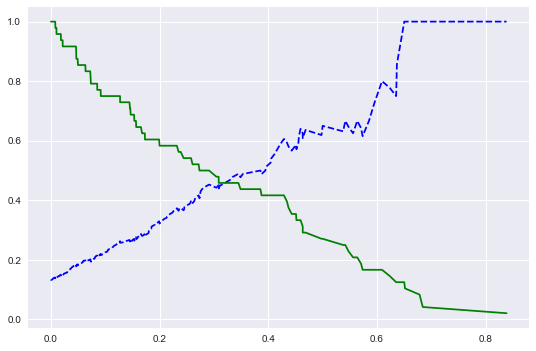

In [32]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(
    y_test, model_log_reg.predict_proba(x_test)[:, 1])
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')


The Training Accuracy is:  0.8720508166969148
The Testing Accuracy is:  0.8858695652173914
The R2 score is:  -0.006250000000000089
Precision: 0.867
Recall: 0.886
F1-Measure: 0.865
ROC_AUC: 0.774
the classification report is 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       320
           1       0.65      0.27      0.38        48

    accuracy                           0.89       368
   macro avg       0.77      0.62      0.66       368
weighted avg       0.87      0.89      0.86       368



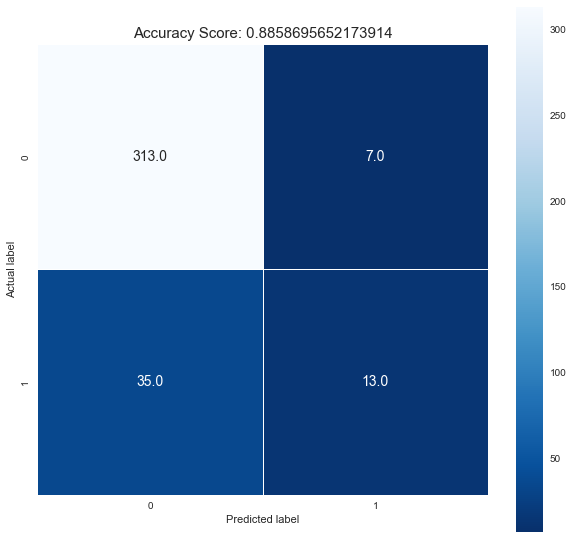

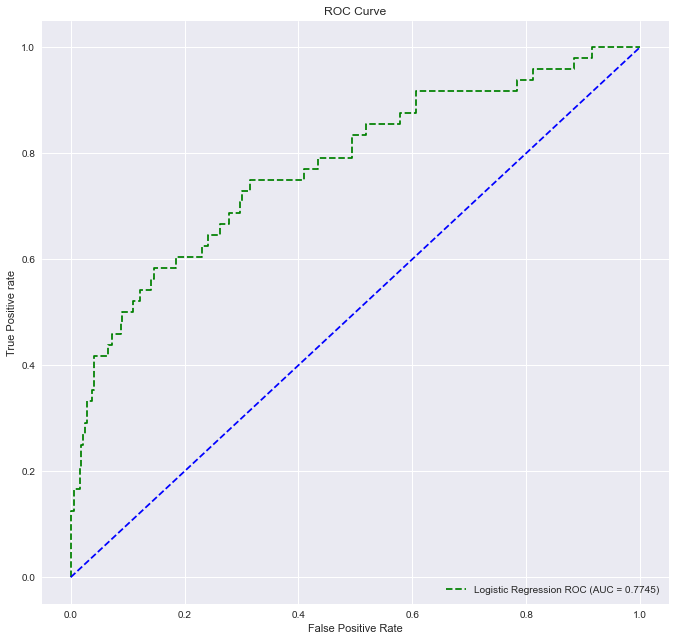

In [33]:
print_metrics(model_log_reg, x_train, x_test, y_train, y_test)
plot_confusion_matrix(model_log_reg, x_test, y_test)
plot_roc(model_log_reg, 'Logistic Regression', x_test, y_test)


### Decision tree

In [34]:
space =dict()
space['max_depth']=[i for i in range(1,50)]
space['max_leaf_nodes']=[i for i in range(2,50)]
space['min_samples_split']=[i for i in range(2,10)]
space['min_samples_leaf']=[i for i in range(1,4)]
# space['criterion']=['gini','entropy']
space['criterion']=['gini' ]

In [35]:
# des_tree = tree.DecisionTreeClassifier(splitter='best',random_state=42)   
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)        
# # random_search = RandomizedSearchCV(des_tree, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=42,error_score='raise' , verbose  = 1)    
# search_result = random_search.fit(x_train, y_train)
# model_tree = search_result.best_estimator_




params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = tree.DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
search_result = tree_cv.fit(x_train, y_train)
model_tree = search_result.best_estimator_


Fitting 3 folds for each of 4332 candidates, totalling 12996 fits


In [36]:
print('Best Score: %s' % search_result.best_score_)
print('Best Hyperparameters: %s' % search_result.best_params_)
print(model_tree)


Best Score: 0.8530017178059471
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 2, 'splitter': 'random'}
DecisionTreeClassifier(max_depth=4, min_samples_leaf=9, random_state=42,
                       splitter='random')


The Training Accuracy is:  0.8656987295825771
The Testing Accuracy is:  0.8478260869565217
The R2 score is:  -0.34166666666666656
Precision: 0.793
Recall: 0.848
F1-Measure: 0.813
ROC_AUC: 0.664
the classification report is 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       320
           1       0.25      0.08      0.12        48

    accuracy                           0.85       368
   macro avg       0.56      0.52      0.52       368
weighted avg       0.79      0.85      0.81       368



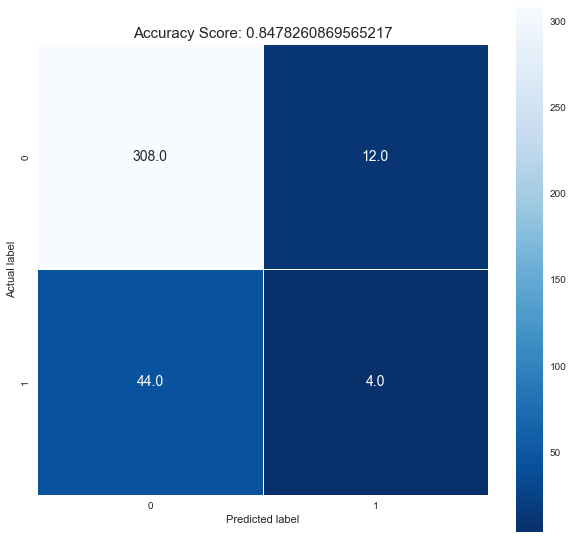

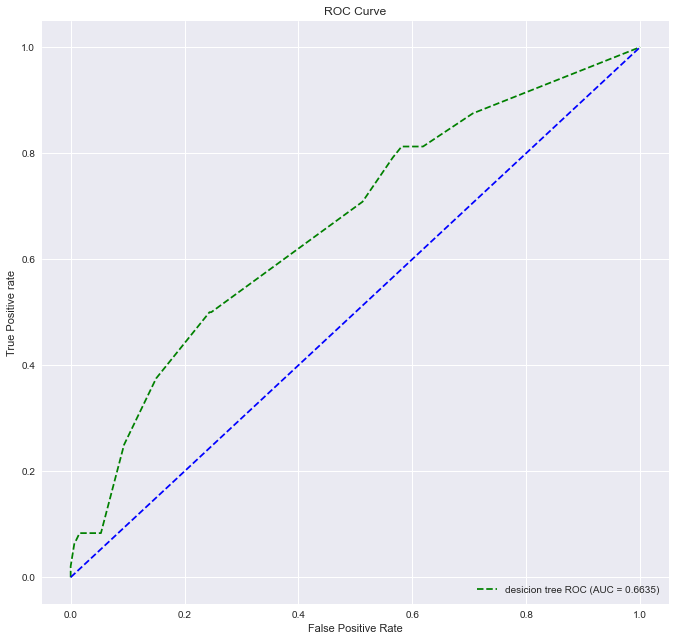

In [37]:
print_metrics(model_tree,x_train,x_test,y_train,y_test)
plot_confusion_matrix(model_tree , x_test , y_test)
plot_roc(model_tree , 'desicion tree',x_test,y_test)

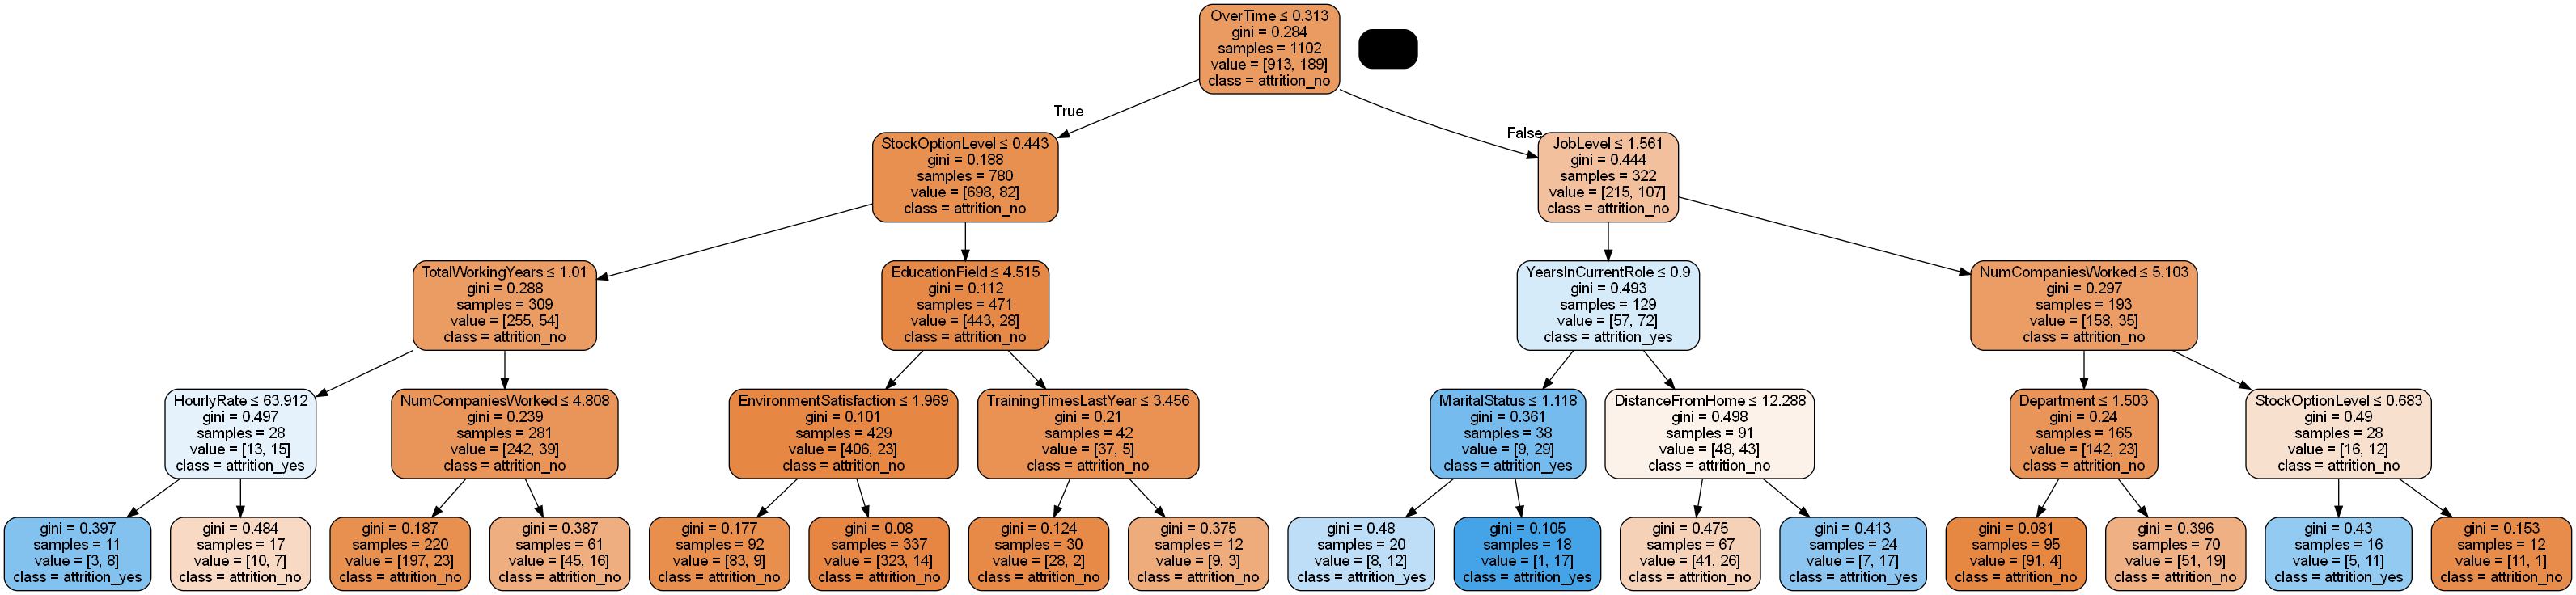

In [38]:
from six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
dot_data = StringIO()
export_graphviz(model_tree, out_file=dot_data, rounded=True, filled=True, special_characters=True,
                feature_names=df.drop(['Attrition'], axis=1).columns, class_names=['attrition_no', 'attrition_yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('desicion_tree_IBM_attrition.png')
Image(graph.create_png())


### SVM

SVC(kernel='linear', probability=True)
The Training Accuracy is:  0.8756805807622504
The Testing Accuracy is:  0.8885869565217391
The R2 score is:  0.017708333333333326
Precision: 0.871
Recall: 0.889
F1-Measure: 0.871
ROC_AUC: 0.782
the classification report is 
               precision    recall  f1-score   support

           0       0.90      0.97      0.94       320
           1       0.65      0.31      0.42        48

    accuracy                           0.89       368
   macro avg       0.78      0.64      0.68       368
weighted avg       0.87      0.89      0.87       368



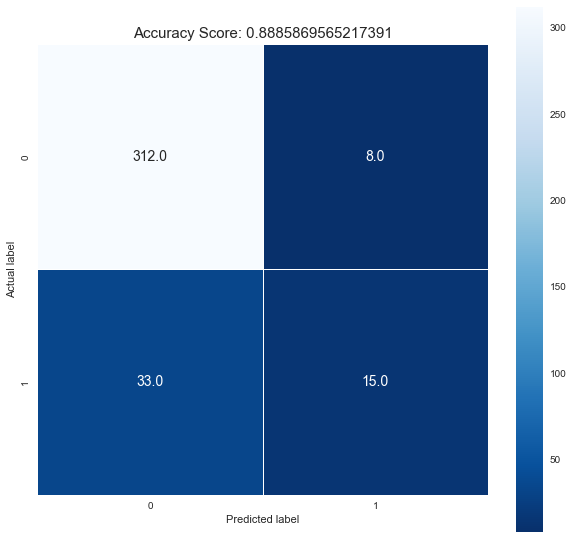

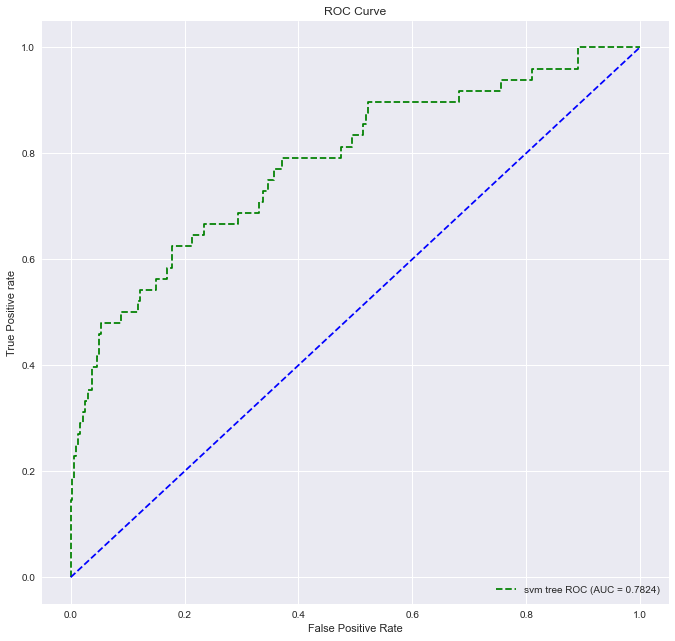

In [41]:
svm_clf = SVC(kernel='linear' , probability=True)
svm_clf.fit(X_train_std, y_train)

print(svm_clf)
print_metrics(svm_clf, X_train_std, X_test_std, y_train, y_test)
plot_confusion_matrix(svm_clf, X_test_std, y_test)
plot_roc(svm_clf , 'svm tree',X_test_std,y_test)
model_SVC  = svm_clf

In [22]:
svm_clf = SVC(random_state=42 , probability=True)

param_grid = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
]


# # param_grid = {
# #     # 'C': np.logspace(-4,4,100),
# #     # 'gamma': np.logspace(-4,4,20),
# #     'C': np.logspace(-2, 10, 13),
# #     'gamma':  np.logspace(-9, 3, 13),
# #     'kernel':  ['rbf'],
# #     #   'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']

# # }
# # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

search = GridSearchCV(svm_clf, param_grid=param_grid,
                      scoring='roc_auc', cv=3, refit=True, verbose=1)
search.fit(X_train_std, y_train)
model_SVC = search.best_estimator_



Fitting 3 folds for each of 12 candidates, totalling 36 fits


The Training Accuracy is:  0.8756805807622504
The Testing Accuracy is:  0.8885869565217391
The R2 score is:  0.017708333333333326
Precision: 0.871
Recall: 0.889
F1-Measure: 0.871
ROC_AUC: 0.782
the classification report is 
               precision    recall  f1-score   support

           0       0.90      0.97      0.94       320
           1       0.65      0.31      0.42        48

    accuracy                           0.89       368
   macro avg       0.78      0.64      0.68       368
weighted avg       0.87      0.89      0.87       368



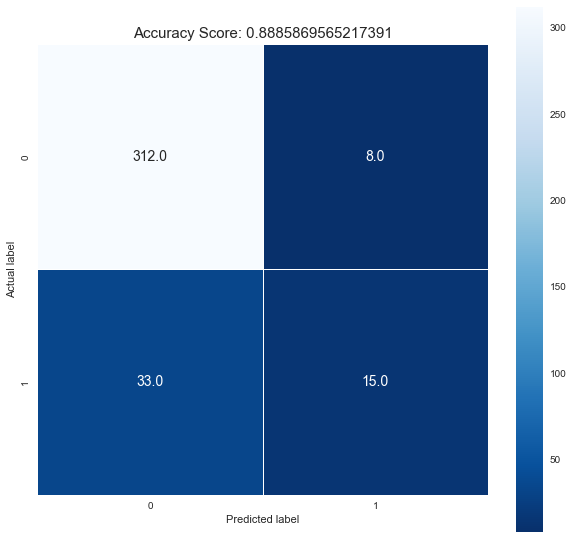

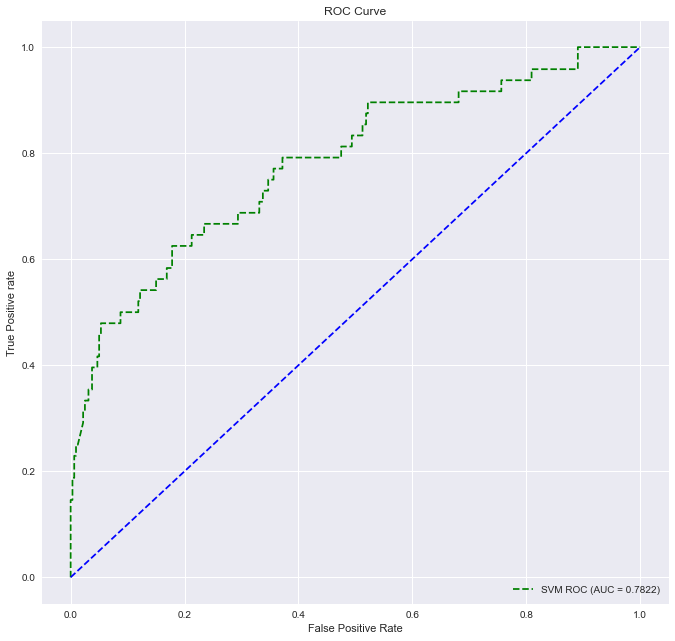

In [42]:
model_SVC.fit(X_train_std, y_train)
print_metrics(model_SVC, X_train_std, X_test_std, y_train, y_test)
plot_confusion_matrix(model_SVC, X_test_std, y_test)
plot_roc(model_SVC , 'SVM',X_test_std,y_test)

### bagging >>  Random forest

The Training Accuracy is:  1.0
The Testing Accuracy is:  0.8722826086956522
The R2 score is:  -0.1260416666666666
Precision: 0.838
Recall: 0.872
F1-Measure: 0.832
ROC_AUC: 0.726
the classification report is 
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       320
           1       0.56      0.10      0.18        48

    accuracy                           0.87       368
   macro avg       0.72      0.55      0.55       368
weighted avg       0.84      0.87      0.83       368



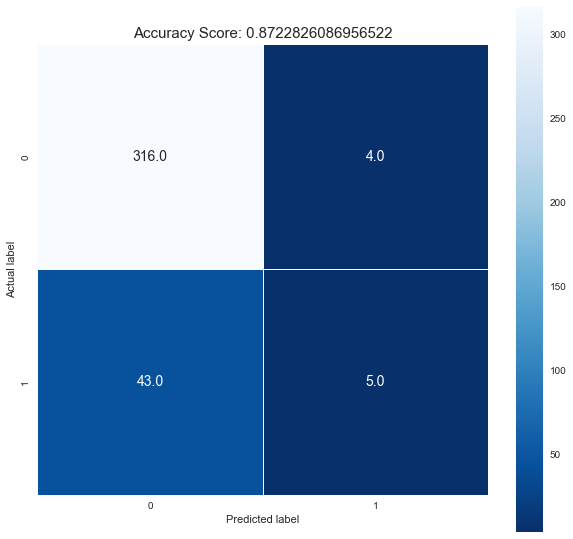

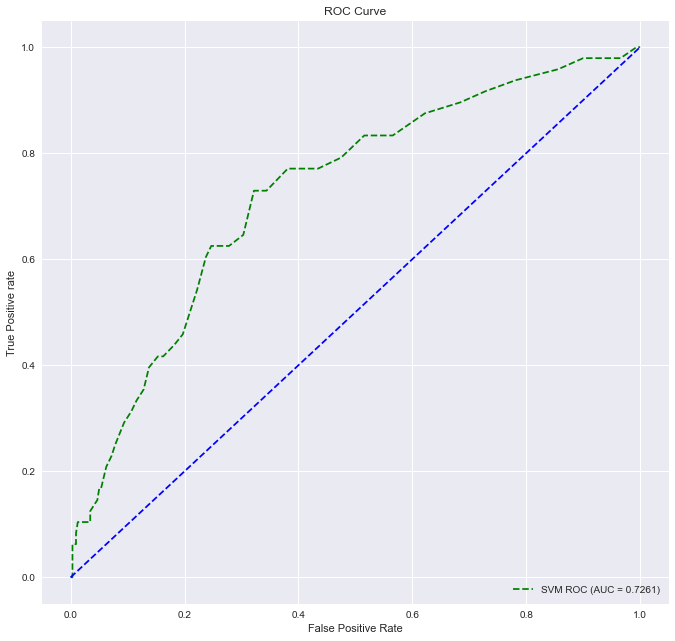

In [43]:
from sklearn.ensemble import RandomForestClassifier


# x_train_norm = normalize(x_train, norm='l2')
# x_test_norm = normalize(x_test, norm='l2')

rf_clf = RandomForestClassifier(n_estimators=100) 

rf_clf.fit(x_train, y_train)


# print_metrics(rf_clf, x_train_norm, x_test_norm, y_train, y_test)
print_metrics(rf_clf, x_train, x_test, y_train, y_test)
plot_confusion_matrix(rf_clf, x_test, y_test)
plot_roc(rf_clf , 'SVM',x_test,y_test)

In [44]:
param_grid = dict(
    n_estimators=[100, 500, 900],
    max_features=['auto', 'sqrt'],
    max_depth=[2, 3, 5, 10, 15, None],
    min_samples_split=[2, 5, 10],
    min_samples_leaf=[1, 2, 4],
    bootstrap=[True, False]
)

rf_clf = RandomForestClassifier(random_state=42)
search = GridSearchCV(rf_clf, param_grid=param_grid,
                      scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
search.fit(x_train, y_train)

rf_clf = RandomForestClassifier(**search.best_params_, random_state=42)
rf_clf.fit(x_train, y_train)
# evaluate(rf_clf, x_train, x_test, y_train, y_test)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


KeyboardInterrupt: 

The Training Accuracy is:  0.9455535390199638
The Testing Accuracy is:  0.875
The R2 score is:  -0.1020833333333333
Precision: 0.847
Recall: 0.875
F1-Measure: 0.834
ROC_AUC: 0.762
the classification report is 
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       320
           1       0.62      0.10      0.18        48

    accuracy                           0.88       368
   macro avg       0.75      0.55      0.56       368
weighted avg       0.85      0.88      0.83       368



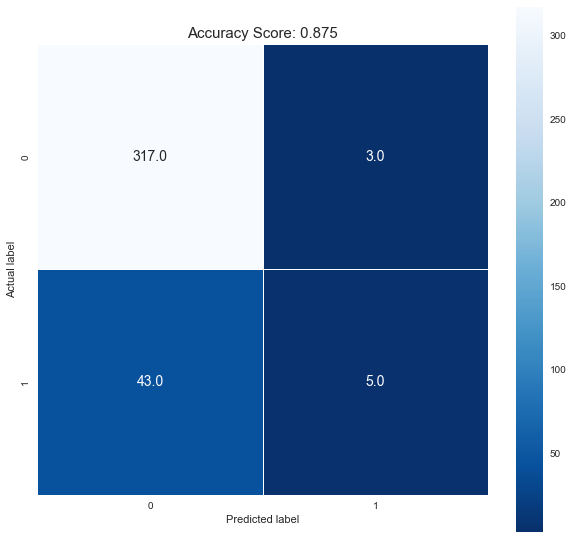

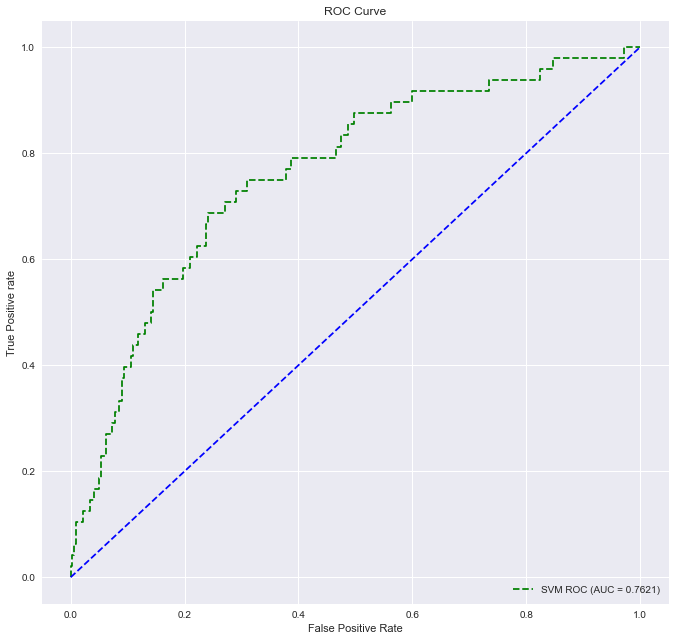

In [ ]:
print_metrics(rf_clf, x_train, x_test, y_train, y_test)
plot_confusion_matrix(rf_clf, x_test, y_test)
plot_roc(rf_clf , 'SVM',x_test,y_test)

### boosting  - XGboost

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)

# evaluate(xgb_clf, X_train, X_test, y_train, y_test)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

The Training Accuracy is:  1.0
The Testing Accuracy is:  0.8804347826086957
The R2 score is:  -0.054166666666666696
Precision: 0.859
Recall: 0.880
F1-Measure: 0.861
ROC_AUC: 0.788
the classification report is 
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       320
           1       0.59      0.27      0.37        48

    accuracy                           0.88       368
   macro avg       0.74      0.62      0.65       368
weighted avg       0.86      0.88      0.86       368



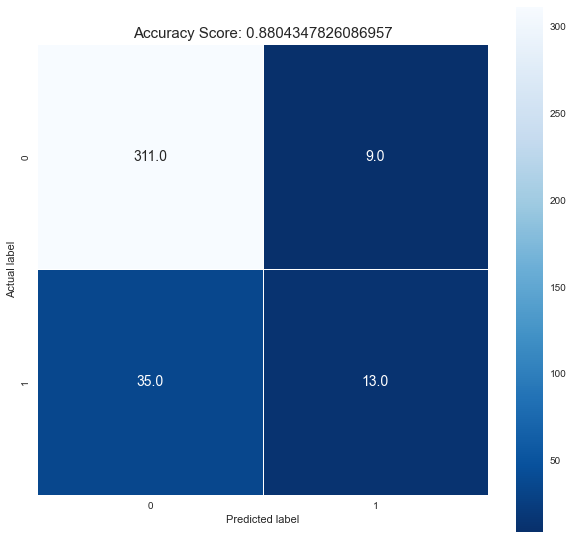

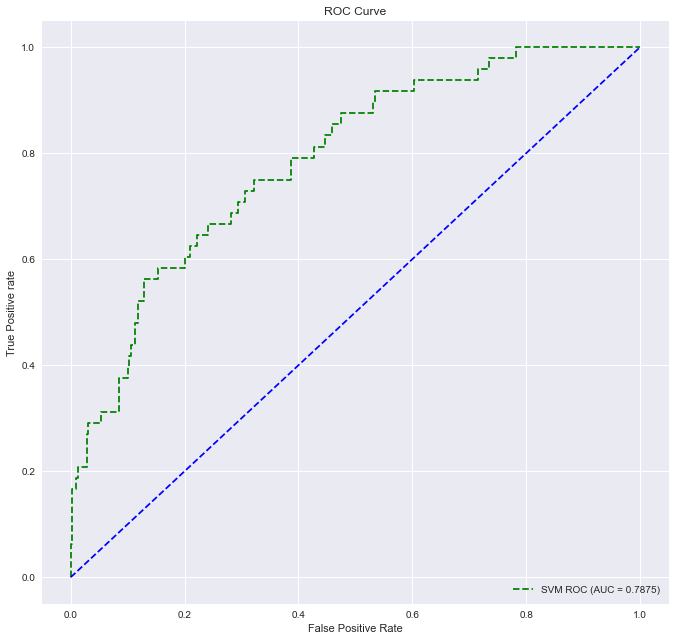

In [ ]:
print_metrics(xgb_clf, x_train, x_test, y_train, y_test)
plot_confusion_matrix(xgb_clf, x_test, y_test)
plot_roc(xgb_clf , 'SVM',x_test,y_test)

In [ ]:
print(x_train.shape, y_train.shape)


(1102, 29) (1102,)


In [ ]:


def random_search_tuning():

    params = {'max_depth': [3, 6, 10, 15],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              'n_estimators': [100, 250, 500, 750],
              'num_class': [10]
              }

    xgbclf = XGBClassifier()
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             scoring='accuracy',
                             n_iter=50,
                             n_jobs=-1,
                             verbose=1)
    return clf
    # clf.fit(x_train, y_train)
    # best_model = clf.best_estimator_
    # # best_combination = clf.best_params_

    # return best_model


xgb_clf = random_search_tuning()
# xgb_clf.fit(x_train, y_train)
# xgb_clf = xgb_clf.best_estimator_



In [ ]:
# xgb_clf.fit(x_train, y_train)

In [ ]:
xgb_clf


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1,
              colsample_bytree=0.7999999999999999, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=10, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', random_state=0, ...)

The Training Accuracy is:  1.0
The Testing Accuracy is:  0.8804347826086957
The R2 score is:  -0.054166666666666696
Precision: 0.859
Recall: 0.880
F1-Measure: 0.861
ROC_AUC: 0.788
the classification report is 
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       320
           1       0.59      0.27      0.37        48

    accuracy                           0.88       368
   macro avg       0.74      0.62      0.65       368
weighted avg       0.86      0.88      0.86       368



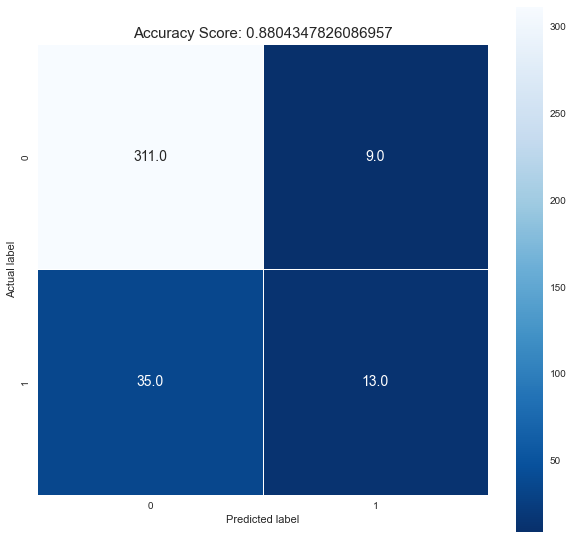

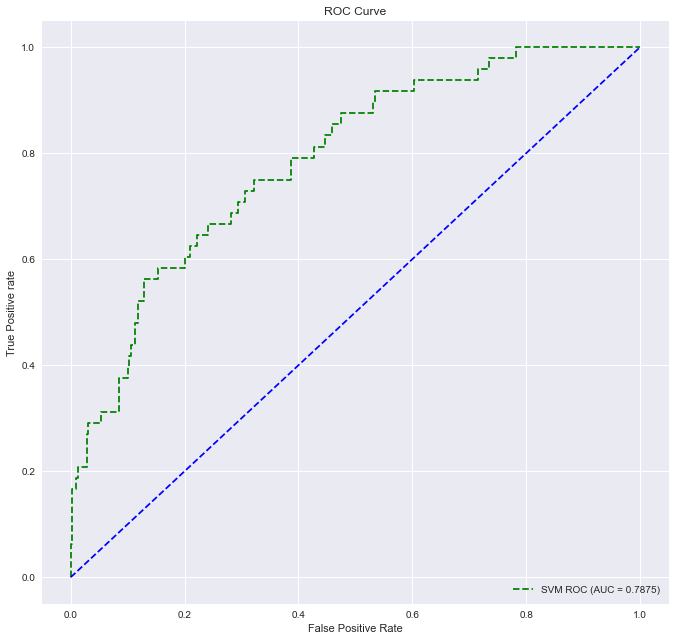

In [ ]:
print_metrics(xgb_clf, x_train, x_test, y_train, y_test)
plot_confusion_matrix(xgb_clf, x_test, y_test)
plot_roc(xgb_clf , 'SVM',x_test,y_test)

### light gradient boost
        we should hyperparameter tune lightgbm and catboost with similar methods as we tuned XGboost 

In [ ]:
from lightgbm import LGBMClassifier

lgb_clf = LGBMClassifier()
lgb_clf.fit(x_train, y_train)



LGBMClassifier()

The Training Accuracy is:  1.0
The Testing Accuracy is:  0.875
The R2 score is:  -0.1020833333333333
Precision: 0.848
Recall: 0.875
F1-Measure: 0.849
ROC_AUC: 0.790
the classification report is 
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       320
           1       0.56      0.21      0.30        48

    accuracy                           0.88       368
   macro avg       0.72      0.59      0.62       368
weighted avg       0.85      0.88      0.85       368



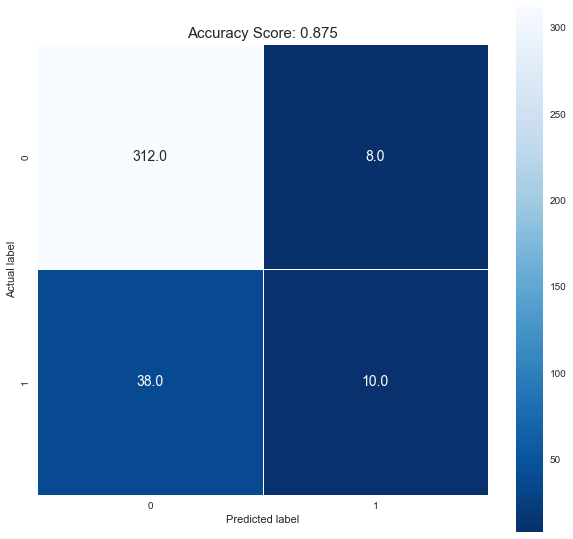

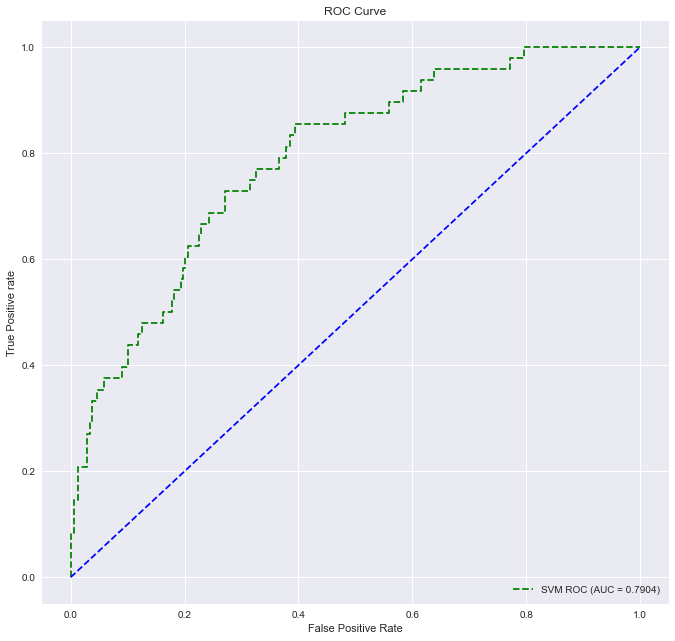

In [ ]:
print_metrics(lgb_clf, x_train, x_test, y_train, y_test)
plot_confusion_matrix(lgb_clf, x_test, y_test)
plot_roc(lgb_clf , 'SVM',x_test,y_test)

### cat boost

In [ ]:
from catboost import CatBoostClassifier

cb_clf = CatBoostClassifier()
cb_clf.fit(x_train, y_train, verbose=0)



The Training Accuracy is:  0.985480943738657
The Testing Accuracy is:  0.8831521739130435
The R2 score is:  -0.030208333333333393
Precision: 0.867
Recall: 0.883
F1-Measure: 0.850
ROC_AUC: 0.785
the classification report is 
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       320
           1       0.73      0.17      0.27        48

    accuracy                           0.88       368
   macro avg       0.81      0.58      0.60       368
weighted avg       0.87      0.88      0.85       368



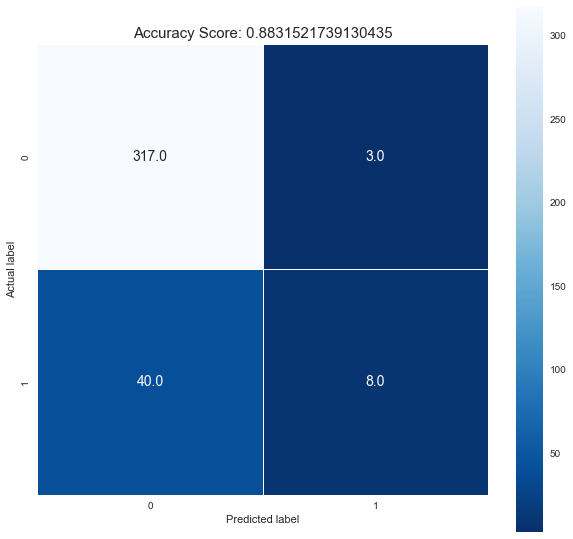

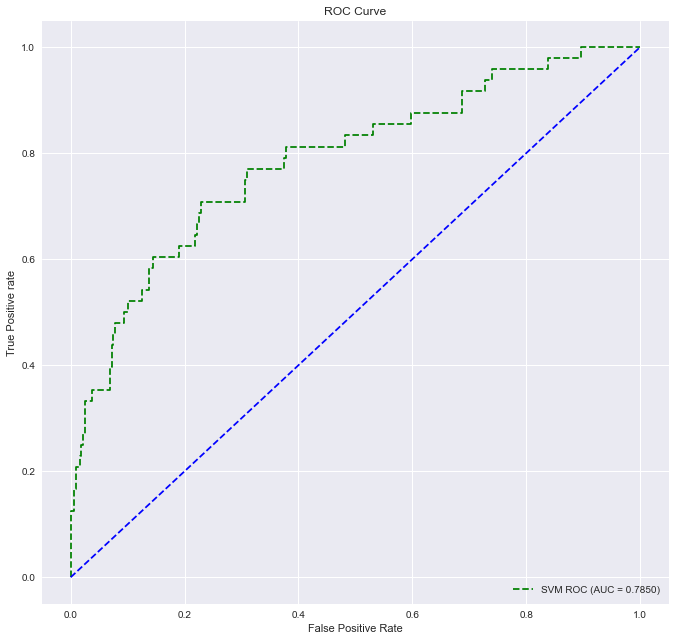

In [ ]:
print_metrics(cb_clf, x_train, x_test, y_train, y_test)
plot_confusion_matrix(cb_clf, x_test, y_test)
plot_roc(cb_clf , 'SVM',x_test,y_test)

## comparison of the results

In [ ]:
models = [model_knn, model_NB, model_log_reg, model_tree,
          model_SVC, rf_clf, xgb_clf, lgb_clf, cb_clf]
model_names = ['KNN', 'Naive Bayes','Logistic regression' , 'desicion tree' , 'support vector machine' , 'Random Forest' , 'XGBoost' , 'LightGBM' , 'CatBoost']
colors = ['red', 'green', 'blue', 'orange', 'black', 'yellow', 'pink', 'purple', 'brown']
index = 0
accuracy = []
precision = []
recall = []
score = []
roc = []
scores_dict = {}


In [ ]:
index = 0
# dictionary for scores 
scores_dict = {}
plt.figure(figsize=(20, 20))
plt.style.use('seaborn')
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')


for model in models:
    # changing x_test only in svm to x_test normalized
    if model == model_SVC:
        test = X_test_std
        train = X_train_std
    else:
        test = x_test

    pred_prob = model.predict_proba(test)
    fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:, 1])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='--',
             color=colors[index], label=f'{model_names[index]} ROC (AUC = %0.4f)' % auc_score)
    index += 1

    y_pred = model.predict(test)


    scores_dict[f'{model_names[index-1]}'] = {
            'r2_score': r2_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred, average='binary'),
            'Test_roc': roc_auc_score(y_test, model.predict_proba(test)[:, 1]),
            'Train_roc': roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]),
            'test_accuracy': model.score(test, y_test),
        }
        

plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right' , fontsize=18)
plt.show()


NameError: name 'plt' is not defined

In [ ]:
pd.DataFrame(scores_dict).hvplot.barh(width=1400, height=2000)


NameError: name 'pd' is not defined

In [ ]:
pd.DataFrame(scores_dict).plot(kind='barh', width=0.8, figsize=(40, 40))
# plt.xlabel(fontsize=20)
# plt.ylabel(fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.show()
